# 공정성 지표 비교: 단일 모델 vs 앙상블

이 노트북은 단일 마진 모델과 앙상블 마진 모델의 공정성 지표(Demographic Parity, Equal Opportunity, Equalized Odds)를 비교하고, 앙상블 기법이 공정성을 얼마나 향상시키는지 시각화하는 것을 목표로 합니다.

## 1단계: 단일 마진 모델 평가

먼저, 훈련 시 저장된 가장 성능이 좋은 단일 모델을 불러와 테스트 데이터셋에 대한 공정성 지표를 직접 계산합니다.

In [4]:
import torch
from torch.utils.data import DataLoader
import os
import re
import numpy as np
import argparse
import sys
from io import StringIO

# 필요한 모듈 및 함수 임포트
import utils.config as config
from utils.dataset import WaterBirds, CelebaDataset
from models.basemodel import NetworkMargin
from utils.utils import demographic_parity_difference, equal_opportunity_difference, equalized_odds_difference
import margin_loss

# --- 설정 ---
COMPARISON_SEED = 4594
DATASET = 'waterbirds'
MODEL_TYPE = 'margin'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# ------------

print(f"Seed: {COMPARISON_SEED}, Dataset: {DATASET}, Model: {MODEL_TYPE}, Device: {DEVICE}")

def get_test_loader(dataset_name):
    if dataset_name == 'waterbirds':
        test_dataset = WaterBirds(split='test')
    elif dataset_name == 'celeba':
        test_dataset = CelebaDataset(split=2)
    return DataLoader(dataset=test_dataset, batch_size=config.base_batch_size, shuffle=False, num_workers=0) # num_workers=0 for notebook safety

print("\n[단일 모델 평가 시작]")
# 1. 모델 경로 설정 및 존재 여부 확인
single_model_filename = config.margin_path if MODEL_TYPE == 'margin' else config.basemodel_path
single_model_path = os.path.join(f'saved_models/seed_{COMPARISON_SEED}', single_model_filename)

single_model_metrics = {}
if not os.path.exists(single_model_path):
    print(f"오류: 단일 모델 파일을 찾을 수 없습니다. 경로: {single_model_path}")
else:
    print(f"모델 로드: {single_model_path}")
    # 2. 모델 및 테스트 데이터 로더 준비
    model = NetworkMargin(config.model_name, config.num_class, DEVICE, config.std, config.mlp_neurons, config.hid_dim).to(DEVICE)
    model.load_state_dict(torch.load(single_model_path, map_location=DEVICE))
    model.eval()
    test_loader = get_test_loader(DATASET)

    # 3. 예측 및 레이블 수집
    all_preds, all_targets, all_sensitive = [], [], []
    with torch.no_grad():
        for _, (_, features, targets, sensitive_attrs, _) in enumerate(test_loader):
            features = features.to(DEVICE).to(torch.float32)
            logits, _, _, _, _ = model(features, m=None, s=None)
            preds = logits.argmax(dim=1).cpu()
            all_preds.append(preds)
            all_targets.append(targets.cpu())
            all_sensitive.append(sensitive_attrs.cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    all_sensitive = torch.cat(all_sensitive)

    # 4. 공정성 지표 계산
    dp_diff = demographic_parity_difference(all_preds, all_sensitive)
    eo_diff = equal_opportunity_difference(all_targets, all_preds, all_sensitive)
    eod_diff = equalized_odds_difference(all_targets, all_preds, all_sensitive)
    
    single_model_metrics = {
        'Demographic Parity': dp_diff,
        'Equal Opportunity': eo_diff,
        'Equalized Odds': eod_diff
    }
    print("\n계산된 단일 모델 공정성 지표:", single_model_metrics)


Seed: 4594, Dataset: waterbirds, Model: margin, Device: cpu

[단일 모델 평가 시작]
모델 로드: saved_models/seed_4594\margin.pth

계산된 단일 모델 공정성 지표: {'Demographic Parity': np.float64(0.06144287193648601), 'Equal Opportunity': np.float64(0.19781931464174451), 'Equalized Odds': np.float64(0.11021786131200308)}


## 2단계: 앙상블 마진 모델 평가

다음으로, `margin_loss.py`의 앙상블 평가 기능(`--test-only`)을 직접 호출하여 동일한 시드에 대한 앙상블 모델의 공정성 지표를 계산합니다.

In [5]:
def parse_fairness_output(output):
    metrics = {}
    dp_match = re.search(r"Demographic Parity Diff(?:erence)?:\s*([\d.]+)", output, re.IGNORECASE)
    if dp_match: metrics['Demographic Parity'] = float(dp_match.group(1))
    eo_match = re.search(r"Equal Opportunity Diff(?:erence)?:\s*([\d.]+)", output, re.IGNORECASE)
    if eo_match: metrics['Equal Opportunity'] = float(eo_match.group(1))
    eod_match = re.search(r"Equalized Odds Diff(?:erence)?:\s*([\d.]+)", output, re.IGNORECASE)
    if eod_match: metrics['Equalized Odds'] = float(eod_match.group(1))
    return metrics

def run_and_capture_output(args_namespace):
    old_stdout = sys.stdout
    redirected_output = StringIO()
    sys.stdout = redirected_output
    try:
        margin_loss.main(args_namespace)
    finally:
        sys.stdout = old_stdout
    return redirected_output.getvalue()

print("\n[앙상블 모델 평가 시작]")
ensemble_args = argparse.Namespace(
    dataset=DATASET,
    seed=COMPARISON_SEED,
    type=MODEL_TYPE,
    train=False, test_only=True, val_only=False, bias=False, clustering=False,
    gpu=DEVICE.index if DEVICE.type == 'cuda' else '0'
)

ensemble_output = run_and_capture_output(ensemble_args)
print(ensemble_output)

ensemble_model_metrics = parse_fairness_output(ensemble_output)
print("\n추출된 앙상블 모델 공정성 지표:", ensemble_model_metrics)


[앙상블 모델 평가 시작]
4594
Evaluating ensemble with Top-5 models (metric=worst, from 100 checkpoints)...

[공정성 지표 계산 - Ensemble 모델]
Demographic Parity Diff: 0.2520
Equal Opportunity Diff: 0.2913
Equalized Odds Diff: 0.2660
Top-5 Ensemble Global Acc: 0.8218846917152405
Top-5 Ensemble Worst Acc: 0.604361355304718
Top-5 Ensemble Avg Acc: 0.796175166964531
VRAM taken:  0.0


추출된 앙상블 모델 공정성 지표: {'Demographic Parity': 0.252, 'Equal Opportunity': 0.2913, 'Equalized Odds': 0.266}


## 3단계: 결과 비교 및 시각화

마지막으로, 두 모델의 결과를 막대그래프로 시각화하여 공정성 지표의 차이를 명확하게 비교합니다. 이 지표들은 값이 낮을수록 더 공정함을 의미합니다.

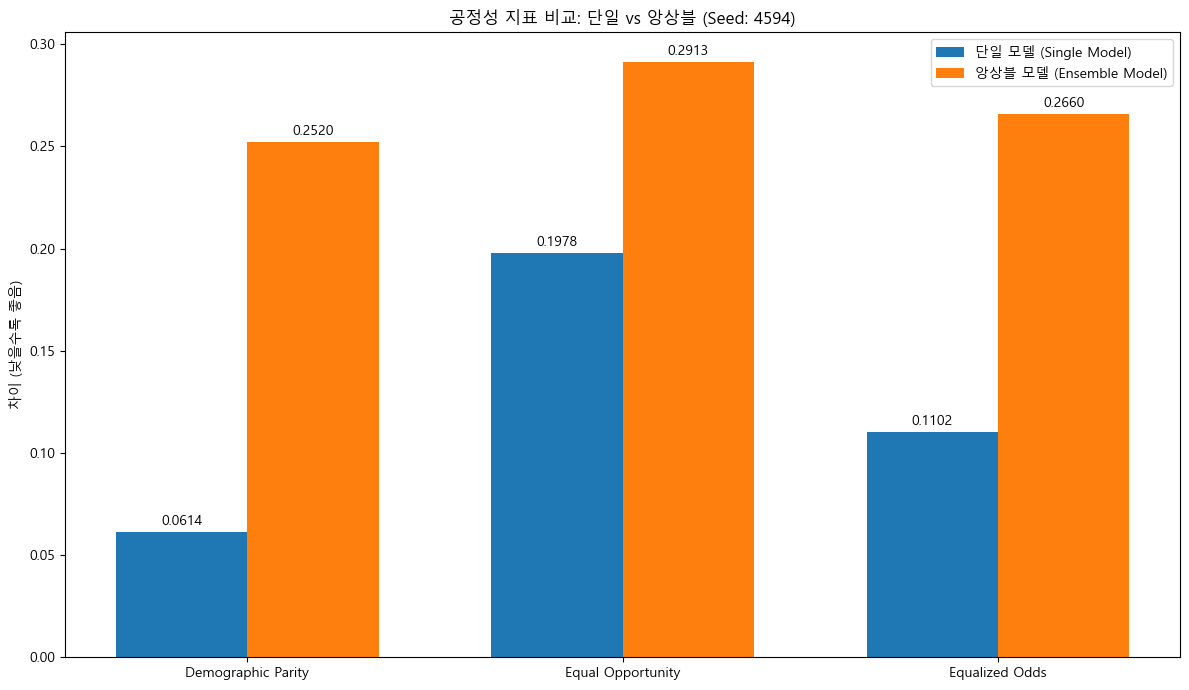

| 지표 (Metric)              | 단일 모델    | 앙상블 모델  | 개선 정도      |
|----------------------------|--------------|--------------|----------------|
| Demographic Parity         | 0.0614       | 0.2520       | -0.1906        |
| Equal Opportunity          | 0.1978       | 0.2913       | -0.0935        |
| Equalized Odds             | 0.1102       | 0.2660       | -0.1558        |


In [6]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
try:
    if os.name == 'nt': # Windows
        plt.rc('font', family='Malgun Gothic')
    elif os.name == 'posix': # Mac or Linux
        plt.rc('font', family='AppleGothic') # for Mac
except Exception as e:
    print(f"한글 폰트 설정 중 오류 발생: {e}. 영문으로 표시됩니다.")
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

if single_model_metrics and ensemble_model_metrics and len(single_model_metrics) == 3 and len(ensemble_model_metrics) == 3:
    labels = list(single_model_metrics.keys())
    single_values = [single_model_metrics[label] for label in labels]
    ensemble_values = [ensemble_model_metrics[label] for label in labels]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width/2, single_values, width, label='단일 모델 (Single Model)')
    rects2 = ax.bar(x + width/2, ensemble_values, width, label='앙상블 모델 (Ensemble Model)')

    ax.set_ylabel('차이 (낮을수록 좋음)')
    ax.set_title(f'공정성 지표 비교: 단일 vs 앙상블 (Seed: {COMPARISON_SEED})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3, fmt='%.4f')
    ax.bar_label(rects2, padding=3, fmt='%.4f')

    fig.tight_layout()
    plt.show()
    
    # 요약 테이블 출력
    print("| 지표 (Metric)              | 단일 모델    | 앙상블 모델  | 개선 정도      |")
    print("|----------------------------|--------------|--------------|----------------|")
    for i, label in enumerate(labels):
        improvement = single_values[i] - ensemble_values[i]
        improvement_str = f"{improvement:+.4f}"
        print(f"| {label:<26} | {single_values[i]:<12.4f} | {ensemble_values[i]:<12.4f} | {improvement_str:<14} |")

else:
    print("\n비교 차트를 생성할 수 없습니다. 하나 또는 두 모델 평가에서 지표를 추출하지 못했습니다.")